In [1]:
import pandas as pd
import numpy as np
import scipy as sp

from scipy import stats, special
from scipy.optimize import minimize 
import pingouin as pg

import pymc3 as pm
import arviz as az

import matplotlib.pyplot as plt
import seaborn as sns

/home/nachshon/anaconda3/envs/risk/lib/python3.8/site-packages/outdated/utils.py:14: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.5.1, the latest is 0.5.3.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  return warn(
/home/nachshon/anaconda3/envs/risk/lib/python3.8/site-packages/outdated/utils.py:14: OutdatedPackageWarning: The package outdated is out of date. Your version is 0.2.1, the latest is 0.2.2.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  return warn(


In [2]:
db_mon = pd.read_csv('data/db_mon.csv')
db_med = pd.read_csv('data/db_med.csv')

print('Participants monetary: ', len(db_mon['sub'].unique()), 'participants medical: ', len(db_med['sub'].unique()))

Participants monetary:  66 participants medical:  68


In [3]:
mon_uniuqe = az.from_netcdf("data/mon_trace.nc")
med_uniuqe = az.from_netcdf("data/med_trace.nc")

In [4]:
df_mon = db_mon[['sub','age', 'gender', 'moca_score']].sort_values('sub').drop_duplicates().reset_index(drop=True)
df_mon['age'] = df_mon.age.astype('int')

df_med = db_med[['sub','age', 'gender', 'moca_score']].sort_values('sub').drop_duplicates().reset_index(drop=True)
df_med['age'] = df_med.age.astype('int')

In [5]:
alpha  = az.summary(mon_uniuqe, var_names=['α'])[['mean']]
beta   = az.summary(mon_uniuqe, var_names=['β'])[['mean']]
level1 = az.summary(mon_uniuqe, var_names=['level1'])[['mean']]
level2 = az.summary(mon_uniuqe, var_names=['level2'])[['mean']]
level3 = az.summary(mon_uniuqe, var_names=['level3'])[['mean']]
level4 = az.summary(mon_uniuqe, var_names=['level4'])[['mean']]

alpha  = alpha.rename(columns={'mean':  "alpha_mon"}).reset_index(drop=True)
beta   = beta.rename(columns={'mean':   "beta_mon"}).reset_index(drop=True)
level1 = level1.rename(columns={'mean': "level1_mon"}).reset_index(drop=True)
level2 = level2.rename(columns={'mean': "level2_mon"}).reset_index(drop=True)
level3 = level3.rename(columns={'mean': "level3_mon"}).reset_index(drop=True)
level4 = level4.rename(columns={'mean': "level4_mon"}).reset_index(drop=True)

df_mon = df_mon.merge(alpha,  left_index=True, right_index=True)
df_mon = df_mon.merge(beta,   left_index=True, right_index=True)
df_mon = df_mon.merge(level1, left_index=True, right_index=True)
df_mon = df_mon.merge(level2, left_index=True, right_index=True)
df_mon = df_mon.merge(level3, left_index=True, right_index=True)
df_mon = df_mon.merge(level4, left_index=True, right_index=True)

In [6]:
alpha  = az.summary(med_uniuqe, var_names=['α'])[['mean']]
beta   = az.summary(med_uniuqe, var_names=['β'])[['mean']]
level1 = az.summary(med_uniuqe, var_names=['level1'])[['mean']]
level2 = az.summary(med_uniuqe, var_names=['level2'])[['mean']]
level3 = az.summary(med_uniuqe, var_names=['level3'])[['mean']]
level4 = az.summary(med_uniuqe, var_names=['level4'])[['mean']]

alpha  = alpha.rename(columns={'mean':  "alpha_med"}).reset_index(drop=True)
beta   = beta.rename(columns={'mean':   "beta_med"}).reset_index(drop=True)
level1 = level1.rename(columns={'mean': "level1_med"}).reset_index(drop=True)
level2 = level2.rename(columns={'mean': "level2_med"}).reset_index(drop=True)
level3 = level3.rename(columns={'mean': "level3_med"}).reset_index(drop=True)
level4 = level4.rename(columns={'mean': "level4_med"}).reset_index(drop=True)

df_med = df_med.merge(alpha,  left_index=True, right_index=True)
df_med = df_med.merge(beta,   left_index=True, right_index=True)
df_med = df_med.merge(level1, left_index=True, right_index=True)
df_med = df_med.merge(level2, left_index=True, right_index=True)
df_med = df_med.merge(level3, left_index=True, right_index=True)
df_med = df_med.merge(level4, left_index=True, right_index=True)

In [7]:
monetary = db_mon.groupby(['sub','value','risk','ambiguity']).mean().reset_index()
medical = db_med.groupby(['sub','value','risk','ambiguity']).mean().reset_index()

In [8]:
monetary = monetary.merge(df_mon, left_on='sub', right_on='sub')
medical  = monetary.merge(df_med, left_on='sub', right_on='sub')

In [9]:
monetary['val'] = (monetary.l1*monetary.level1_mon + 
                   monetary.l2*monetary.level2_mon + 
                   monetary.l3*monetary.level3_mon + 
                   monetary.l4*monetary.level4_mon)

monetary['SVsafe']  = (monetary.l1 *  monetary.level1_mon) ** monetary.alpha_mon
monetary['SVlotto'] = monetary.val ** monetary.alpha_mon   * (monetary.risk - monetary.beta_mon * monetary.ambiguity/2)

medical['val'] = (medical.l1*medical.level1_med + 
                  medical.l2*medical.level2_med + 
                  medical.l3*medical.level3_med + 
                  medical.l4*medical.level4_med)

medical['SVsafe'] = (medical.l1 * medical.level1_mon) ** medical.alpha_mon
medical['SVlotto'] = medical.val ** medical.alpha_mon * (medical.risk - medical.beta_mon * medical.ambiguity/2)

In [10]:
def inv_logit(p):
    return np.exp(p) / (1 + np.exp(p))

In [11]:
monetary['p'] = inv_logit(monetary.SVlotto - monetary.SVsafe)
medical['p']  = inv_logit(medical.SVlotto  - medical.SVsafe)

In [12]:
sp.stats.spearmanr(monetary.choice, monetary.p)

SpearmanrResult(correlation=0.8712126325816062, pvalue=0.0)

In [13]:
sp.stats.spearmanr(medical.choice, medical.p)

SpearmanrResult(correlation=0.7897151392661118, pvalue=0.0)

In [14]:
def corr(df):
    with pm.Model() as RR:

        a = pm.Normal('intercept', 0, 1)
        b = pm.Normal('slope', 0, 1)
        eps = pm.Exponential('eps', 1)
        y_hat = a + b*df.x

        nu = pm.InverseGamma("nu", alpha=3, beta=1)

        #likelihood = pm.Normal("likelihood", mu=y_hat, sigma=eps, observed=y)

        likelihood = pm.StudentT(
            "likelihood", mu=y_hat, sigma=eps, nu=nu, observed=df.y
        )

        trace_robust = pm.sample(tune=3000, draws=1000, return_inferencedata=True, target_accept=0.95)
        
    return(trace_robust)

In [15]:
mon_r = corr(pd.DataFrame({'x': monetary.choice, 'y': monetary.p}).reset_index(drop=True))
med_r = corr(pd.DataFrame({'x': medical.choice,  'y': medical.p}).reset_index(drop=True))

mon_trace = az.summary(mon_r, var_names=['slope','intercept'], hdi_prob=.89)[['mean','hdi_5.5%','hdi_94.5%']]
med_trace = az.summary(med_r, var_names=['slope','intercept'], hdi_prob=.89)[['mean','hdi_5.5%','hdi_94.5%']]

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [nu, eps, slope, intercept]


Sampling 4 chains for 3_000 tune and 1_000 draw iterations (12_000 + 4_000 draws total) took 8 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [nu, eps, slope, intercept]


Sampling 4 chains for 3_000 tune and 1_000 draw iterations (12_000 + 4_000 draws total) took 7 seconds.


/home/nachshon/anaconda3/envs/risk/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/home/nachshon/anaconda3/envs/risk/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0.1, 0.1, 'β = 0.39,\n89% HDPi [0.38, 0.40]')

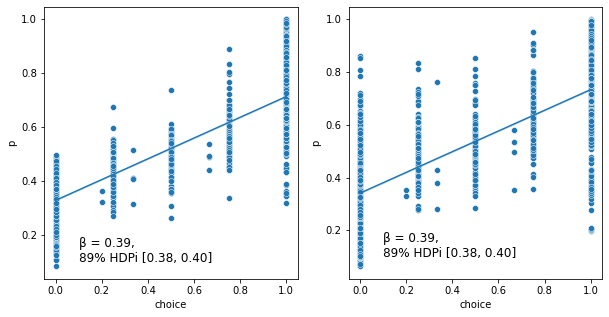

In [16]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
sns.scatterplot(x = 'choice', y = 'p', data=monetary, ax=axes[0])
sns.scatterplot(x = 'choice', y = 'p', data=medical, ax=axes[1])

sns.lineplot(monetary.choice,mon_trace['mean']['intercept']+mon_trace['mean']['slope']*monetary.choice, ax=axes[0])
sns.lineplot(medical.choice,med_trace['mean']['intercept']+med_trace['mean']['slope']*medical.choice, ax=axes[1])


text = 'β = {:.2f},\n89% HDPi [{:.2f}, {:.2f}]'.format(float(mon_trace['mean']['slope']),
                                                       float(mon_trace['hdi_5.5%']['slope']),
                                                       float(mon_trace['hdi_94.5%']['slope']))
axes[0].text(0.1, 0.1, text, fontsize=12)

text = 'β = {:.2f},\n89% HDPi [{:.2f}, {:.2f}]'.format(float(med_trace['mean']['slope']),
                                                       float(med_trace['hdi_5.5%']['slope']),
                                                       float(med_trace['hdi_94.5%']['slope']))
axes[1].text(0.1, 0.1, text, fontsize=12)

In [17]:
mon_beta = az.from_netcdf("data/mon_trace_beta.nc")

In [18]:
df_mon2 = db_mon[['sub','age', 'gender', 'moca_score']].sort_values('sub').drop_duplicates().reset_index(drop=True)
df_mon2['age'] = df_mon2.age.astype('int')

In [19]:
alpha  = az.summary(mon_beta, var_names=['α'])[['mean']]
beta   = az.summary(mon_beta, var_names=['β'])[['mean']]

alpha  = alpha.rename(columns={'mean':  "alpha_mon"}).reset_index(drop=True)
beta   = beta.rename(columns={'mean':   "beta_mon"}).reset_index(drop=True)

df_mon2 = df_mon2.merge(alpha,  left_index=True, right_index=True)
df_mon2 = df_mon2.merge(beta,   left_index=True, right_index=True)

In [20]:
monetary2 = db_mon.groupby(['sub','value','risk','ambiguity']).mean().reset_index()
monetary2 = monetary2.merge(df_mon2, left_on='sub', right_on='sub')

In [21]:
monetary2.head()

,sub,value,risk,ambiguity,choice,catch,age_x,moca_score_x,level,l1,l2,l3,l4,subn,age_y,gender,moca_score_y,alpha_mon,beta_mon
0,10,5,0.25,0.00,0.0,0.0,18.0,28.0,1.0,1.0,0.0,0.0,0.0,0.0,18,M,28,0.889,0.49
1,10,5,0.50,0.00,0.0,0.0,18.0,28.0,1.0,1.0,0.0,0.0,0.0,0.0,18,M,28,0.889,0.49
2,10,5,0.50,0.24,0.0,0.0,18.0,28.0,1.0,1.0,0.0,0.0,0.0,0.0,18,M,28,0.889,0.49
3,10,5,0.50,0.50,0.0,0.0,18.0,28.0,1.0,1.0,0.0,0.0,0.0,0.0,18,M,28,0.889,0.49
4,10,5,0.50,0.74,0.0,0.0,18.0,28.0,1.0,1.0,0.0,0.0,0.0,0.0,18,M,28,0.889,0.49


In [22]:
monetary2['SVsafe']  = 5 ** monetary2.alpha_mon
monetary2['SVlotto'] = monetary2.value ** monetary2.alpha_mon * (monetary2.risk - monetary2.beta_mon * monetary2.ambiguity/2)

monetary2['p'] = inv_logit(monetary2.SVlotto - monetary2.SVsafe)

In [24]:
sp.stats.spearmanr(monetary2.choice, monetary2.p)

SpearmanrResult(correlation=0.7914418640518699, pvalue=0.0)